In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix;

In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [7]:
data.shape

(59381, 128)

In [8]:
#Reset response data to get balance
data['Response'].value_counts()

8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64

In [9]:
data['risk'] = pd.Series([1 if x == 8 else 0 for x in data['Response']], index = data['Response'].index)

In [10]:
data.drop('Response',axis = 1, inplace = True)

In [11]:
missing = data.isnull().sum()/len(data)
print(missing[missing>0].sort_values(ascending = False))

Medical_History_10     0.990620
Medical_History_32     0.981358
Medical_History_24     0.935990
Medical_History_15     0.751015
Family_Hist_5          0.704114
Family_Hist_3          0.576632
Family_Hist_2          0.482579
Insurance_History_5    0.427679
Family_Hist_4          0.323066
Employment_Info_6      0.182786
Medical_History_1      0.149694
Employment_Info_4      0.114161
Employment_Info_1      0.000320
dtype: float64


In [12]:
#drop missing data
data = data.dropna(thresh=data.shape[0]*0.6,how='all',axis = 1)

In [13]:
data.shape

(59381, 120)

In [14]:
data = data.fillna(data.mean())

In [15]:
#drop unimportant data
data.drop('Product_Info_2',axis = 1, inplace = True)

In [16]:
#BMI is related to weight and height
data.drop('BMI',axis = 1, inplace = True)

In [17]:
data.drop('Id',axis = 1,inplace = True)

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, random_state=99)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
train.shape, test.shape

((41566, 117), (17815, 117))

In [19]:
#baseline model accuracy
ACC = 1 - np.sum(test['risk'])/len(test['risk'])
ACC

0.6707830479932642

In [20]:
y_train = train['risk']
X_train = train.drop(['risk'],axis = 1)
y_test = test['risk']
X_test = test.drop(['risk'],axis = 1)

In [21]:
# We use LDA, CART, Random Forest, XGBoost Model in this case
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score
from sklearn.metrics import roc_curve, auc
import warnings
# Defining the metrics function to return the result of the model
def metrics(y_true,y_pred,y_prob):
    cm = confusion_matrix(y_true,y_pred)
    accuracy = accuracy_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred)
    FPR = cm[0,1]/sum(cm[0])
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    return [accuracy,recall,FPR,precision,roc_auc,fpr,tpr]
# Defining the check_importance function to return the feature importance
def check_importance(model, X_train):
  #Checking importance of features
    importances = model.feature_importances_
  #List of columns and their importances
    importance_dict = {'Feature' : list(X_train.columns),
                    'Feature Importance' : importances}
    importance_df = pd.DataFrame(importance_dict)
  #Rounding it off to 2 digits as we might get exponential numbers
    importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
    return importance_df.sort_values(by=['Feature Importance'],ascending=False)
# Defining the model
def model(x_train, y_train, x_test, y_test, model_name = 'LDA',scoring = 'accuracy'):
    if model_name == 'LDA':
        clf = LinearDiscriminantAnalysis()
        clf.fit(x_train,y_train)
        pred = clf.predict(x_test)
        prob = clf.predict_proba(x_test)[:,1]
        return metrics(y_test,pred,prob)
    if model_name == 'CART':
        clf = DecisionTreeClassifier()
        # Tuning the hyper parameter ccp_alpha
        grid_values = {'ccp_alpha': np.linspace(0.0, 0.002, 21),
#                'min_samples_leaf': [3,4,5,6,7],
#                'min_samples_split': [10,15,20,25,30],
               'random_state': [1]}
        # Using HalvingGridSearchCV method to tune the parameter. Faster than GridSearch
        cv = HalvingGridSearchCV(clf,param_grid = grid_values,scoring=scoring,cv=5)
        cv.fit(x_train,y_train)
        # printing the best parameters of the estimator
        print(cv.best_params_,flush=True)
        pred = cv.best_estimator_.predict(x_test)
        prob = cv.best_estimator_.predict_proba(x_test)[:,1]
        # return the metrics and feature importance of the model
        return metrics(y_test,pred,prob), check_importance(cv.best_estimator_,x_train)
    if model_name == 'Random Forest':
        clf = RandomForestClassifier()
        # Tuning the hyperparameter min_sample_leaf. n_estimators and max_features can also be tuned
        grid_values = {#'n_estimators': np.linspace(100,1000,10,dtype=int),
#                       'max_features': np.linspace(5,50,10),
                      'min_samples_leaf': np.linspace(1,5,5,dtype=int),
                      'random_state': [1],
                      'verbose': [0]}
        cv = HalvingGridSearchCV(clf, param_grid= grid_values, scoring = scoring,cv=5)
        cv.fit(x_train,y_train)
        # printing the best parameters of the estimator
        print(cv.best_params_,flush=True)
        pred = cv.best_estimator_.predict(x_test)
        prob = cv.best_estimator_.predict_proba(x_test)[:,1]
        return metrics(y_test,pred,prob),check_importance(cv.best_estimator_,x_train)
    if model_name == 'XGB':
        clf = XGBClassifier(use_label_encoder=False)
        # Tuning the learning rate in this case
        grid_values = {#'n_estimators': np.linspace(100,1000,10,dtype=int),
#                       'max_features': np.linspace(5,100,20),
#                       'min_samples_leaf': np.linspace(2,20,10),
                      'learning_rate': np.linspace(0.02,0.2,10),
                      'random_state': [1],
                      'verbosity':[0]}
        cv = HalvingGridSearchCV(clf, param_grid=grid_values,scoring=scoring, cv=5)
        cv.fit(x_train,y_train)
        # printing the best parameters of the estimator
        print(cv.best_params_,flush=True)
        pred = cv.best_estimator_.predict(x_test)
        prob = cv.best_estimator_.predict_proba(x_test)[:,1]
        return metrics(y_test,pred,prob),check_importance(cv.best_estimator_,x_train)
def plot_feature_importance(model, X_train):
  # PLotting features vs their importance factors
    fig = plt.figure(figsize = (15, 8))
  # Extracting importance values
    values =check_importance(model, X_train)[check_importance(model, X_train)['Feature Importance']>0]['Feature Importance'].values
  # Extracting importance features
    features = check_importance(model, X_train)[check_importance(model, X_train)['Feature Importance']>0]['Feature'].values
    plt.bar(features, values, color ='blue',
          width = 0.4)
    plt.xticks( rotation='vertical')
    plt.show()

In [19]:
# Run the models and fit the data then make prediction and lastly evaluate
ld_me = model(X_train,y_train,X_test,y_test,'LDA')
cart_me, cart_fi = model(X_train,y_train,X_test,y_test,'CART')
rf_me, rf_fi = model(X_train,y_train,X_test,y_test,'Random Forest')
xgb_me, xgb_fi = model(X_train,y_train,X_test,y_test,'XGB')

{'ccp_alpha': 0.0011, 'random_state': 1}
{'min_samples_leaf': 2, 'random_state': 1, 'verbose': 0}
{'learning_rate': 0.12000000000000002, 'random_state': 1, 'verbosity': 0}


In [20]:
# Printing out the metrics for each model
metric_all = pd.DataFrame()
col_name = ['LDA','CART','Random Forest','XGBoost']
for me,name in zip([ld_me,cart_me,rf_me,xgb_me],col_name):
    metric_all[name] = me[0:5]
metric_all.index = ['Accuracy','Recall','FPR','Precision','AUC']
metric_all

,LDA,CART,Random Forest,XGBoost
Accuracy,0.805782,0.802582,0.815605,0.825091
Recall,0.659335,0.740494,0.657971,0.742882
FPR,0.122343,0.166946,0.107029,0.134561
Precision,0.725652,0.685232,0.751070,0.730427
AUC,0.871432,0.855899,0.890339,0.904031


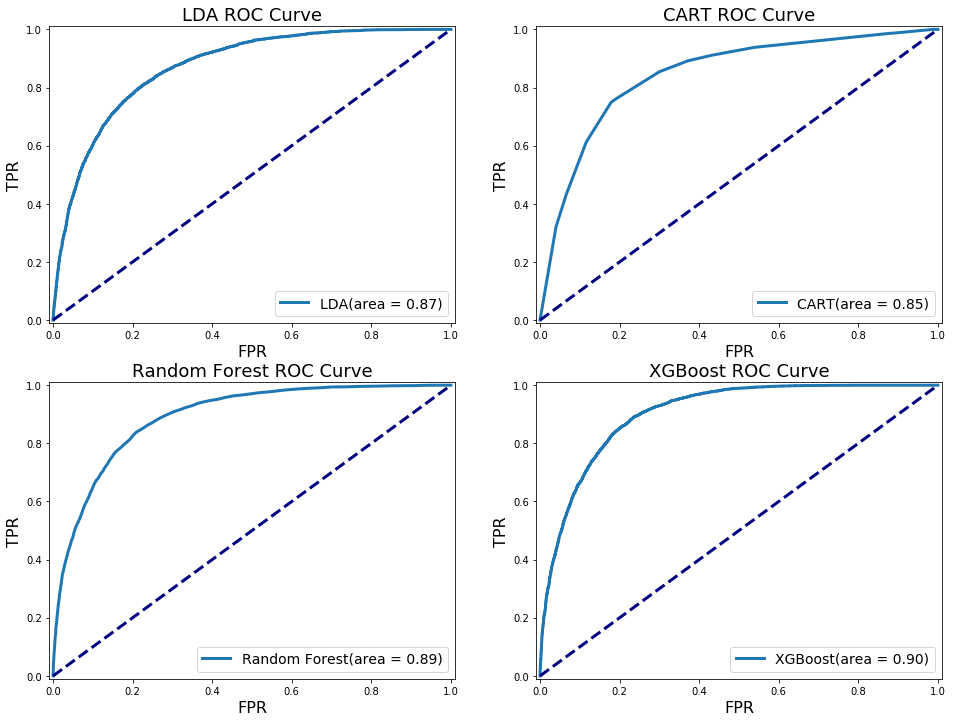

In [21]:
list=[221,222,223,224]
plt.figure(figsize=(16, 12)) 
for me,name,i in zip([ld_me,cart_me,rf_me,xgb_me],col_name,range(4)):
    tpr = me[-1]
    fpr = me[-2]
    roc_auc = me[-3]
    a = list[i]
    plt.subplot(a)
    plt.title(name+' '+'ROC Curve', fontsize=18)
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label=name+'(area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.legend(loc='lower right', fontsize=14)
    plt.show

In [21]:
#Bootstrap for final model
import time
def bootstrap_validation(test_data, test_label, model, metrics, sample=100, random_state=99):
    tic = time.time()
    n_sample = sample
    n_metrics = 3
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        bs_prob = model.predict_proba(bs_data)[:,1]
        output_array[bs_iter,:] = metrics(bs_label,bs_predicted,bs_prob)[0:3]
        if bs_iter % 20 == 0:
            print(bs_iter, time.time()-tic)
    output_df = pd.DataFrame(output_array)
    return output_df

In [22]:
final_model = XGBClassifier(use_label_encoder=False,learning_rate=0.12, random_state=1, verbosity=0)
final_model.fit(X_train,y_train)
bs_df = bootstrap_validation(X_test,y_test,final_model,metrics)

(100, 3)
0 0.06268477439880371
20 1.1571509838104248
40 2.2557969093322754
60 3.368259906768799
80 4.476579904556274


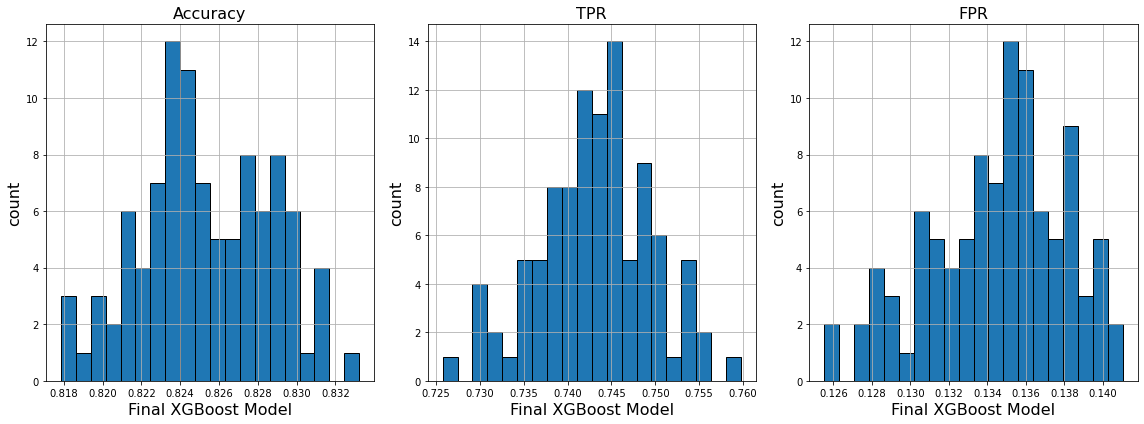

In [23]:
#visualization of the outcome
fig, ax = plt.subplots(1,3,figsize = (16,6))
for name, i in zip(['Accuracy','TPR','FPR'], range(3)):
    ax[i].set_xlabel('Final XGBoost Model',fontsize=16)
    ax[i].set_ylabel('count',fontsize=16)
    ax[i].hist(bs_df[i],bins=20,edgecolor = 'black')
    ax[i].set_title(name,fontsize=16)
    ax[i].grid()
fig.tight_layout()

In [24]:
#the confidence interval of three factors
CI1= np.quantile(bs_df.iloc[:,0]-xgb_me[0],np.array([0.025,0.975]))
print("The 95-percent confidence interval of acc is %s" % CI1)
CI2= np.quantile(bs_df.iloc[:,1]-xgb_me[1],np.array([0.025,0.975]))
print("The 95-percent confidence interval of acc is %s" % CI2)
CI3= np.quantile(bs_df.iloc[:,2]-xgb_me[2],np.array([0.025,0.975]))
print("The 95-percent confidence interval of acc is %s" % CI3)

The 95-percent confidence interval of acc is [-0.00633315  0.00628964]
The 95-percent confidence interval of acc is [-0.01323232  0.01209476]
The 95-percent confidence interval of acc is [-0.00710744  0.00552891]


In [27]:
# Show the Top 15 features with greatest importance of the final model
check_importance(final_model,X_train).head(15)

,Feature,Feature Importance
51,Medical_History_23,0.18
82,Medical_Keyword_15,0.08
34,Medical_History_4,0.07
70,Medical_Keyword_3,0.05
8,Wt,0.05
90,Medical_Keyword_23,0.03
57,Medical_History_30,0.03
35,Medical_History_5,0.02
21,InsuredInfo_7,0.02
16,InsuredInfo_2,0.02


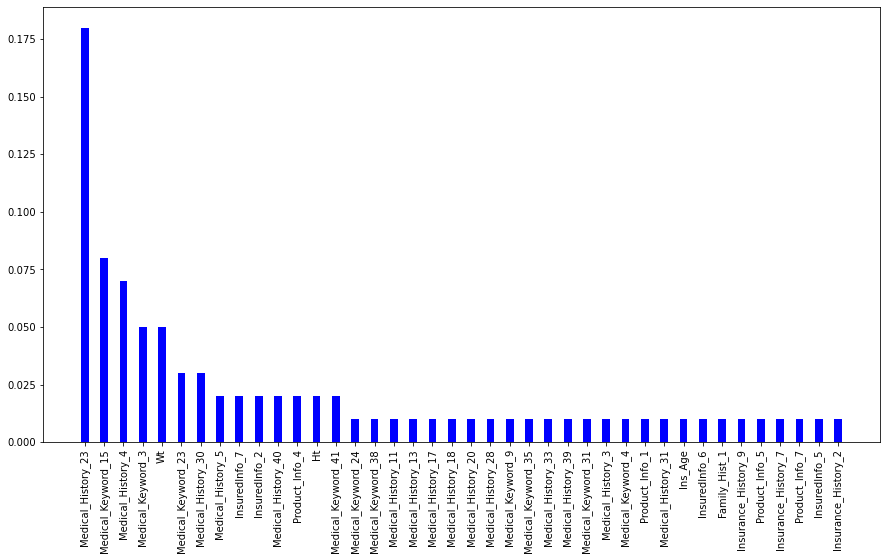

In [25]:
# plot the feature importance
plot_feature_importance(final_model,X_train)